# One Class Support Vector Machines

## Importing Libraries

In [2]:
# Data Processing
import numpy as np
import pandas as pd
from collections import Counter

# Importing tde
import tde

import matplotlib.pyplot as plt

# Model and Performance
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report #for model performance evaluation

# To generate the for loops
import glob
import os
from matplotlib import ticker

## Data Management

In [3]:
# READ INFECTION TIME DATA
infection_data = pd.read_excel('/Users/yoddmena/Downloads/Research/Telemetry_edited/MRSA - Master sheet.xlsx', index_col=0)

# READ AND EXTRACT DATA FROM FOLDER CONTAINING EXCEL SHEETS
folder = "/Users/yoddmena/Downloads/Research/Telemetry_edited/"
files = glob.glob( folder + "Ex *.xlsx" ) 

In [4]:
# CREATE A LIST OF TEMPERATURES
temp = []

for file in files:
    df = pd.read_excel(file)
    file_temp = df.iloc[:, 3::2]  # slicing the data for only temperature
    
    # Ensure that the number of minutes matches the number of temperature columns
    num_temp_columns = file_temp.shape[1]
    
    # Iterate over every other column in file_temp
    for j in range(0, num_temp_columns):
        # Extract the specific temperature column and its corresponding minutes
        column_name = file_temp.columns[j]
        temperature = file_temp[column_name]
        
        # Append the temperature and minutes to each lists
        temp.append(temperature)

## Creating Data Frames

In [5]:
##### INFECTION DATA
infection_data = infection_data.iloc[:,[1,9]]
infection_data = infection_data.T # transpose the data

infection_data.columns = infection_data.iloc[0] # Assign the values of the first row as the new column names

infection_data = infection_data[1:] # Remove the first row (previous column names)


##### TEMPERATURE DATA
df_temp = pd.DataFrame(temp)
df_temp = df_temp.T # transpose the data

df_temp.columns = df_temp.columns.astype(str).str.split(' ').str[0] # Rename columns keeping only the first word


## Scores

In [6]:
# IMPORTING THE SVM MODEL
# this model is from SckiKit Learn
model = svm.OneClassSVM()

# SIGMOID DEFINITION
# we will use the sigmoid function to make our scores be a numerical value that lies between 0 and 1

beta = (2/700) # 700 is the largest value
def sigmoid(scores, beta):
    return 1 / (1 + np.exp(-beta * scores))

In [9]:
#fig,ax = plt.subplots(2,1,figsize=(15,10), sharex = False)
#fig.set_facecolor("white")

train_end = 5760
shift = 2*360 # since the period is 6 hours (360) and we do this twice

# LISTS
# First anomalies after infection
min_scores = []
first_anom_train = []
first_anom_inf = []
score_train = []
score_infec = []
tpr = []

for i in range(0, df_temp.shape[1]): #df_temp.shape[1]
    #ax[0].cla()  # clear axis 0-1
    #ax[1].cla()
    
    #mice_min = range(0, df_temp.shape[0]) # Get the specific minutes for the current temperature time series
    
    temp_value = df_temp.iloc[:, i] # extract the temperature values for the current column
    mice_temp = df_temp.iloc[:, i].to_frame() # converting temp list to data frame
    
    names = mice_temp.columns[0] # get the column name for the current file
    
    # Filing in missing data
    temp_value_fw = temp_value.fillna(method='ffill') # foward fill
    temp_value_bw = temp_value_fw.fillna(method='bfill') # backward fill after forward fill
    
    # Time Delay Embedding
    temp_tde = tde.tde(temp_value_bw) # using the tde file
    temp_tde = temp_tde.T # transporting the data
    
    ##################################################################
    # Fit the Data on the first 4 days (4*24*60) 
    model.fit(temp_tde[:train_end+1,:])
    
    # Predict the Data
    predict_train_data = model.predict(temp_tde[:train_end+1,:]) # predict on training data
    predict_test_data = model.predict(temp_tde[train_end+1:,:]) # predicting on test data
    
    # Scores
    scores_train_data = model.score_samples(temp_tde[:train_end+1,:]) # scores on training data 
    scores_test_data = model.score_samples(temp_tde[train_end+1:,:]) # scores on test data
    
    threshold = model.offset_
    
    ##################################################################
    # Combine training and testing scores and predictions
    combined_scores= np.concatenate((scores_train_data, scores_test_data), axis=0)
    combined_predictions = np.concatenate((predict_train_data, predict_test_data), axis=0)
    
    time = np.arange(temp_tde.shape[0])+(shift) # 2 times the time delay shift
    
    # Minimum score
    min_score = scores_train_data.min()
    
    # Find the indices of the anomalies
    anomaly_indices = np.where(combined_scores <= min_score)[0] #finding the values where its -1 (anomaly)
    time_2 = anomaly_indices + (shift) # shifting the time for plotting
    '''
    ##################################################################
    # Plotting 1st Graph
    ax[0].plot(time, combined_scores, '-', color='#6693F5', alpha=0.75)  # Plot the scores with blue color #[:100]
    ax[0].grid()
    ax[0].set_ylabel("Score", fontsize=14)
    ax[0].set_title(f"Anomalies found using SckiKit Learn's threshold for '{names}'", fontsize=14)
    ax[0].set_xlim(-10,26000)
    ax[0].set_ylim(0,700)
    ax[0].axhline(y = threshold, color='red', linestyle='-', label='threshold')
    # Plot the anomalies with red color
    #ax[0].plot(time_2, combined_scores[anomaly_indices], '', color='purple') #[:100]
    #ax[0].axhline(y=min_score, color='red', linestyle='-')
    '''
    ##################################################################
    # Plotting infection time
    matching_columns = set(mice_temp.columns).intersection(infection_data.columns)
    
    if matching_columns:
        column_name = matching_columns.pop()
        infection_time = infection_data.loc['Aprprox Infection Minute', column_name]
        # Add a vertical line at the infection time
        #ax[1].axvline(x = infection_time, color='purple', linestyle='-', label='Infection time')
        print(f"Found '{column_name}' and its infection value is '{infection_time}'")
    else:
        print(f"No match found for mouse '{names}'")
    
    ##################################################################
    # Find the index at which the first score is less than min_score
    boolean = combined_scores < min_score
    anom_train = np.argmax(boolean) #+shift
    anom_infec = np.argmax(boolean[infection_time-shift:]) + infection_time 
    
    # Get the corresponding value
    value = combined_scores[anom_train]
    value_1 = combined_scores[anom_infec-shift]
    
    # Calculating the time first anomaly was found after training and infection
    time_aft_train = (anom_train + shift) - train_end
    time_aft_infection = anom_infec - infection_time
    
    # Calculating the amount of false negatives (between end of train and infection time)
    count_false_neg = np.count_nonzero(boolean[train_end:infection_time])
    
    # Calculating the amount of true positives (infection time)
    count_true_pos = np.count_nonzero(boolean[infection_time:]) 
    
    # Calculating true positive rate
    # Check if the denominator is zero
    if (count_true_pos + count_false_neg) == 0:
        print("Skipping division ")
        continue  # Skip this iteration and move to the next number
    
    TPR = count_true_pos / (count_true_pos + count_false_neg)
    
    '''
    ##################################################################
    # Plotting 2nd Graph
    ax[1].plot(time, combined_scores, '-', color='#6693F5', alpha=0.75)  # Plot the scores with blue color #[:100]
    ax[1].plot(time_2, combined_scores[anomaly_indices], '', color='purple') #coloring anomalies
    ax[1].grid()
    ax[1].set_ylabel("Score", fontsize=14)
    ax[1].set_xlabel("Minutes", fontsize=14)
    ax[1].set_title(f"Anomalies found using our threshold for '{names}'", fontsize=14)
    #ax[1].set_xlim(infection_time-5,infection_time+30)
    ax[1].set_xlim(-10,26000)
    ax[1].set_ylim(0,700)
    
    ##################################################################
    # Plotting Horizontal and Vertical Lines
    ax[1].axvline(x = anom_train+shift, color='blue', linestyle='--', label='First anomaly after training') # when the first value is less the minimum value
    ax[1].axvline(x = train_end, color='green', linestyle='-', label='End of training data')
    ax[1].axhline(y=min_score, color='red', linestyle='-', label='Threshold')
    ax[1].axvline(x = anom_infec, color='orange', linestyle ='-', label='First anomaly after infection')
    #ax[1].axhline(y=value, color='blue', linestyle='--', label='value')
    #ax[1].axhline(y=value_1, color='orange', linestyle='-', label='value_1')
    ax[1].legend()
    '''
    ##################################################################
    # Print Values
    print("Minimum Score: ", min_score)
    print("After Training Min: ", anom_train+shift)
    print("After Infection Min: ", anom_infec)
    print(f"First anomaly found after training: {time_aft_train} minutes with score {value}")
    print(f"First anomaly found after infection: {time_aft_infection} minutes with score {value_1}")
    print(f"True Positve Rate: {TPR*100}%")
    
    ##################################################################
    # Appending to Lists
    min_scores.append(min_score)
    first_anom_train.append(time_aft_train)
    first_anom_inf.append(time_aft_infection)
    score_train.append(value)
    score_infec.append(value_1)
    tpr.append(TPR)
   

Found 'CC006-315' and its infection value is '10300'
Minimum Score:  349.54576079540476
After Training Min:  11048
After Infection Min:  11048
First anomaly found after training: 5288 minutes with score 345.7153275046626
First anomaly found after infection: 748 minutes with score 345.7153275046626
True Positve Rate: 100.0%
Found 'CC006-316' and its infection value is '10300'
Minimum Score:  368.954491866093
After Training Min:  6949
After Infection Min:  10463
First anomaly found after training: 1189 minutes with score 363.84915270259853
First anomaly found after infection: 163 minutes with score 320.3102136970141
True Positve Rate: 98.43221641561635%
Found 'CC006-317' and its infection value is '10300'
Minimum Score:  387.14532068752135
After Training Min:  6702
After Infection Min:  12657
First anomaly found after training: 942 minutes with score 381.9142879271862
First anomaly found after infection: 2357 minutes with score 381.9227896952819
True Positve Rate: 99.84514796971783%
Foun

Found 'CC001-364' and its infection value is '10250'
Minimum Score:  275.3274330857812
After Training Min:  6992
After Infection Min:  10251
First anomaly found after training: 1232 minutes with score 259.3191001815971
First anomaly found after infection: 1 minutes with score 269.12823466720226
True Positve Rate: 0.6369426751592357%
Found 'CC001-366' and its infection value is '10250'
Skipping division 
Found 'CC003-225' and its infection value is '10250'
Minimum Score:  300.02925719958523
After Training Min:  10997
After Infection Min:  10997
First anomaly found after training: 5237 minutes with score 274.47929747729154
First anomaly found after infection: 747 minutes with score 274.47929747729154
True Positve Rate: 100.0%
Found 'CC017-455' and its infection value is '10250'
Minimum Score:  209.5032132427251
After Training Min:  7335
After Infection Min:  10403
First anomaly found after training: 1575 minutes with score 207.1182719421554
First anomaly found after infection: 153 minute

Found 'CC061-555' and its infection value is '10500'
Minimum Score:  350.7661445783366
After Training Min:  6963
After Infection Min:  10518
First anomaly found after training: 1203 minutes with score 350.33970340215114
First anomaly found after infection: 18 minutes with score 329.53798598827547
True Positve Rate: 4.3478260869565215%
Found 'CC061-556' and its infection value is '10500'
Minimum Score:  339.86921942213314
After Training Min:  10178
After Infection Min:  10520
First anomaly found after training: 4418 minutes with score 334.3604707686092
First anomaly found after infection: 20 minutes with score 282.3482531144371
True Positve Rate: 99.47916666666666%
Found 'B6-117' and its infection value is '10500'
Minimum Score:  320.1990323295582
After Training Min:  10523
After Infection Min:  10523
First anomaly found after training: 4763 minutes with score 283.90578351541643
First anomaly found after infection: 23 minutes with score 283.90578351541643
True Positve Rate: 56.000000000

Found 'CC053-428' and its infection value is '11500'
Minimum Score:  347.1984292216209
After Training Min:  6845
After Infection Min:  11500
First anomaly found after training: 1085 minutes with score 340.59873905898786
First anomaly found after infection: 0 minutes with score 200.34529614919234
True Positve Rate: 85.27648234510326%
Found 'CC057-730' and its infection value is '11500'
Minimum Score:  317.4883045657711
After Training Min:  8507
After Infection Min:  11700
First anomaly found after training: 2747 minutes with score 298.1670203609134
First anomaly found after infection: 200 minutes with score 315.7284915341813
True Positve Rate: 17.24137931034483%
Found 'CC057-731' and its infection value is '11500'
Minimum Score:  273.6000233442843
After Training Min:  10727
After Infection Min:  11674
First anomaly found after training: 4967 minutes with score 266.3804975546764
First anomaly found after infection: 174 minutes with score 263.5190624043925
True Positve Rate: 98.8702885899

Found 'CC012-1348' and its infection value is '10250'
Minimum Score:  387.53874198639664
After Training Min:  8540
After Infection Min:  10277
First anomaly found after training: 2780 minutes with score 378.47771812712926
First anomaly found after infection: 27 minutes with score 353.5322806367525
True Positve Rate: 97.08108108108108%
Found 'CC012-1349' and its infection value is '10250'
Minimum Score:  334.1546738012097
After Training Min:  7708
After Infection Min:  10279
First anomaly found after training: 1948 minutes with score 332.7394527012786
First anomaly found after infection: 29 minutes with score 314.01952784671664
True Positve Rate: 91.32841328413284%
Found 'CC012-1350' and its infection value is '10250'
Minimum Score:  271.54698688499934
After Training Min:  7418
After Infection Min:  10281
First anomaly found after training: 1658 minutes with score 267.3312949454944
First anomaly found after infection: 31 minutes with score 219.81383558132893
True Positve Rate: 70.977011

Found 'CC042-331' and its infection value is '10000'
Minimum Score:  225.74222803298971
After Training Min:  7151
After Infection Min:  10101
First anomaly found after training: 1391 minutes with score 205.6980488313411
First anomaly found after infection: 101 minutes with score 221.30289500774313
True Positve Rate: 77.77777777777779%
Found 'CC042-332' and its infection value is '10000'
Minimum Score:  265.7150609672455
After Training Min:  7161
After Infection Min:  10000
First anomaly found after training: 1401 minutes with score 68.26428308414563
First anomaly found after infection: 0 minutes with score 219.54742331509857
True Positve Rate: 74.22784810126582%
Found 'CC006-510' and its infection value is '10500'
Minimum Score:  101.08318031518547
After Training Min:  16943
After Infection Min:  16943
First anomaly found after training: 11183 minutes with score 97.3225889193211
First anomaly found after infection: 6443 minutes with score 97.3225889193211
True Positve Rate: 100.0%
Foun

Found 'CC017-394' and its infection value is '10200'
Minimum Score:  334.2059763111285
After Training Min:  7064
After Infection Min:  14233
First anomaly found after training: 1304 minutes with score 325.0984851213483
First anomaly found after infection: 4033 minutes with score 316.3854554378034
True Positve Rate: 79.24528301886792%
Found 'CC017-395' and its infection value is '10200'
Minimum Score:  313.3249476072924
After Training Min:  7067
After Infection Min:  13829
First anomaly found after training: 1307 minutes with score 284.851857181359
First anomaly found after infection: 3629 minutes with score 312.98672538957993
True Positve Rate: 50.0%
Found 'CC024-371' and its infection value is '10200'
Minimum Score:  260.2125491774949
After Training Min:  10081
After Infection Min:  10218
First anomaly found after training: 4321 minutes with score 242.31056079286577
First anomaly found after infection: 18 minutes with score 183.1306022790734
True Positve Rate: 52.94117647058824%
Found

In [10]:
# Make all lists into arrays
ms = np.array(min_scores)
fat = np.array(first_anom_train)
fai = np.array(first_anom_inf)
st = np.array(score_train)
si = np.array(score_infec)
tprs = np.array(tpr)

In [11]:
# Create the data for the table (calculates statistics)
data = {
    'column_1': [round(np.mean(ms),2), round(np.mean(fat),2), round(np.mean(fai),2), round(np.mean(st),2), round(np.mean(si),2), round(np.mean(tprs)*100,2)],
    'column_2': [round(np.std(ms),2), round(np.std(fat),2), round(np.std(fai),2), round(np.std(st),2), round(np.std(si),2), round(np.std(tprs)*100,2)],
    'column_3': [round(np.percentile(ms, 25),2), round(np.percentile(fat, 25),2), round(np.percentile(fai, 25),2), round(np.percentile(st, 25),2), round(np.percentile(si, 25),2), round(np.percentile(tprs, 25)*100,2)],
    'column_4': [round(np.percentile(ms, 50),2), round(np.percentile(fat, 50),2), round(np.percentile(fai, 50),2), round(np.percentile(st, 50),2), round(np.percentile(si, 50),2), round(np.percentile(tprs, 50)*100,2)],
    'column_5': [round(np.percentile(ms, 75),2), round(np.percentile(fat, 75),2), round(np.percentile(fai, 75),2), round(np.percentile(st, 75),2), round(np.percentile(si, 75),2), round(np.percentile(tprs, 75)*100,2)]
}

In [12]:
# Create a DataFrame
df = pd.DataFrame(data)

# Set row names (index)
row_names = ['Minimum Score', 'First Anomaly Time After Training', 'First Anomaly Time After Infection', 'First Anomaly Score After Training', 'First Anomaly Score After Infection  ', 'True Positive Rate']
df.index = row_names

# Set column names
column_names = ['Mean', 'Standard Deviation', 'Quartile 1 (25%)', 'Quartile 2 (Med)', 'Quartile 3 (75%)']
df.columns = column_names


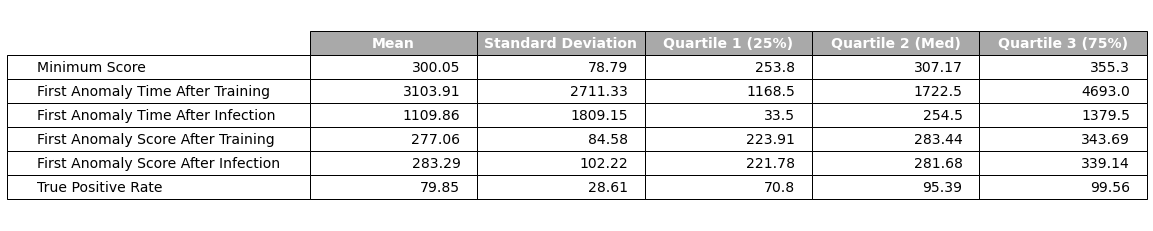

In [14]:
# Saving the Table
# Create a table visualization using matplotlib
fig, ax = plt.subplots(figsize=(6, 4))
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, rowLabels=df.index, loc='center')
table.auto_set_font_size(False)
table.set_fontsize(14)
table.scale(2.5, 2)  # Adjust the scaling factor as per your requirements

# Modify the column names as dark color boxes
for i, col_name in enumerate(df.columns):
    cell = table[0, i]
    cell.set_text_props(weight='bold', color='white')
    cell.set_facecolor('darkgray')
    
# Save the table as an image file
plt.savefig('table_statistics_4days.png', bbox_inches='tight', facecolor='white')
